In [101]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
# set random seed
SEED = 321
np.random.seed(SEED)

In [102]:
## Customization Options
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(12,4)
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
sns.set_context("talk", font_scale=0.9)


In [103]:
# Custom Functions
def format_xdates(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major 
    ticks every year. Includes different grid options for visibility"""
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), 
                       fontweight=xtick_fontweight) 
    
    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax



# Part 1 
1. Load in the Zillow Home Value Index dataframe
2. Filter the 4 largest cities into a new dataframe
3. Melt the data into a long-form and prepare it for a time series analysis 
4. Resample the dataframe as monthly frequency, grouped by City 

In [126]:
# loading and exploring the data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv'
df = pd.read_csv(url)
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


In [127]:
df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName', '2000-01-31', '2000-02-29',
       ...
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30'],
      dtype='object', length=281)

In [129]:
df.drop(["StateName", 'RegionType', 'RegionID'], axis=1, inplace=True)


In [130]:
# filter the dataframe to include the 4 largest cities 
largest_cities = df[df['SizeRank'].isin([0, 1, 2, 3])]
largest_cities

,SizeRank,RegionName,State,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,257207.0,260310.0,263204.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,235513.0,237589.0,240113.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,2,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,108878.0,108881.0,108834.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,167368.0,168826.0,170499.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


In [132]:
# melting the data to convert it to to long-form
melted_df = pd.melt(largest_cities.drop(columns=['SizeRank','Metro']), 
                    id_vars = ['RegionName','State','CountyName'],
                    var_name = 'Date',value_name = 'HomeValue')
melted_df

,RegionName,State,CountyName,Date,HomeValue
0,New York,NY,Queens County,2000-01-31,253690.0
1,Los Angeles,CA,Los Angeles County,2000-01-31,234181.0
2,Houston,TX,Harris County,2000-01-31,109068.0
3,Chicago,IL,Cook County,2000-01-31,166139.0
4,New York,NY,Queens County,2000-02-29,255517.0
...,...,...,...,...,...
1087,Chicago,IL,Cook County,2022-08-31,315587.0
1088,New York,NY,Queens County,2022-09-30,781622.0
1089,Los Angeles,CA,Los Angeles County,2022-09-30,966595.0
1090,Houston,TX,Harris County,2022-09-30,272639.0


In [133]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  1092 non-null   object 
 1   State       1092 non-null   object 
 2   CountyName  1092 non-null   object 
 3   Date        1092 non-null   object 
 4   HomeValue   1087 non-null   float64
dtypes: float64(1), object(4)
memory usage: 42.8+ KB


In [134]:
melted_df['Date'] = pd.to_datetime(melted_df['Date'])
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionName  1092 non-null   object        
 1   State       1092 non-null   object        
 2   CountyName  1092 non-null   object        
 3   Date        1092 non-null   datetime64[ns]
 4   HomeValue   1087 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 42.8+ KB


In [135]:
# setting the "Date" column as the index 
melted_df.set_index('Date', inplace=True)


In [136]:
resampled_df = melted_df.groupby('RegionName').resample('M').mean()
resampled_df

/var/folders/mm/04nbg7g95pgdtd1s3081zgfh0000gn/T/ipykernel_24506/2750058758.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = melted_df.groupby('RegionName').resample('M').mean()
/var/folders/mm/04nbg7g95pgdtd1s3081zgfh0000gn/T/ipykernel_24506/2750058758.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = melted_df.groupby('RegionName').resample('M').mean()
/var/folders/mm/04nbg7g95pgdtd1s3081zgfh0000gn/T/ipykernel_24506/2750058758.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to F

HomeValue
RegionName Date                 
Chicago    2000-01-31   166139.0
           2000-02-29   166536.0
           2000-03-31   167368.0
           2000-04-30   168826.0
           2000-05-31   170499.0
...                          ...
New York   2022-05-31   768797.0
           2022-06-30   773944.0
           2022-07-31   777692.0
           2022-08-31   779960.0
           2022-09-30   781622.0

[1092 rows x 1 columns]

In [137]:
resampled_df.isna().sum()


HomeValue    5
dtype: int64

In [138]:
resampled_df = resampled_df.dropna()
resampled_df.isna().sum()

HomeValue    0
dtype: int64

# Part 2
1. Plot the home values for all 4 cities
2. Answer the following 2 questions using pandas:
    -  Which City had the highest Typical Home Value at the end of 2008? Which had the least?
    -  How much did the home values change from November 2008 to December 2008 (in dollars)?
3. Melt the data into a long-form and prepare it for a time series analysis 
4. Resample the dataframe as monthly frequency, grouped by City 

In [139]:
df_unstacked = resampled_df.unstack(level=0)
df_unstacked

HomeValue                                
RegionName   Chicago   Houston Los Angeles  New York
Date                                                
2000-01-31  166139.0  109068.0    234181.0  253690.0
2000-02-29  166536.0  109079.0    234401.0  255517.0
2000-03-31  167368.0  108878.0    235513.0  257207.0
2000-04-30  168826.0  108881.0    237589.0  260310.0
2000-05-31  170499.0  108834.0    240113.0  263204.0
...              ...       ...         ...       ...
2022-05-31  312487.0  265558.0    990391.0  768797.0
2022-06-30  314663.0  268901.0    992337.0  773944.0
2022-07-31  315910.0  271059.0    992630.0  777692.0
2022-08-31  315587.0  272400.0    978196.0  779960.0
2022-09-30  315429.0  272639.0    966595.0  781622.0

[273 rows x 4 columns]

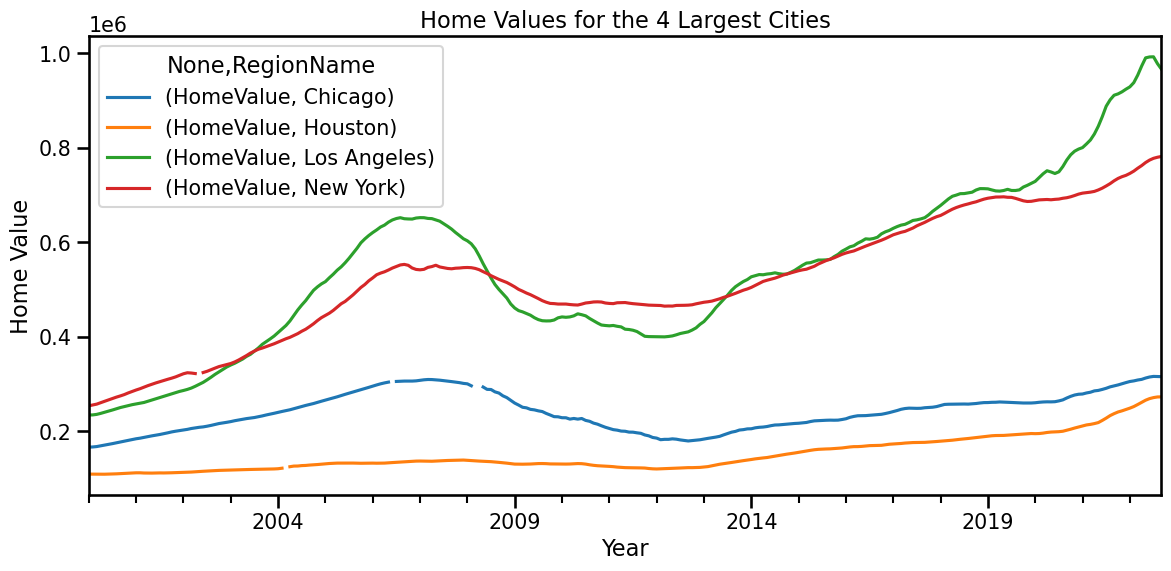

In [140]:
# Plotting the home values for all 4 cities
ax = df_unstacked.plot(figsize=(12, 6))



# Title and axis labels
plt.title("Home Values for the 4 Largest Cities")
plt.xlabel("Year")
plt.ylabel("Home Value")

# Formatting y-axis ticks in thousands of dollars
def format_ticks(x, pos):
    'The two args are the value and tick position'
    return f'{int(x/1000)}K'


plt.tight_layout()
# display the plot
plt.show()


## Which City had the highest Typical Home Value at the end of 2008? Which had the least?

In [141]:
# creating a max column and temperature data frame for the first part of the question
max_cols = ['HomeValue']
plot_df = df_unstacked.loc['2008', max_cols]
# pulling max values
max_value = plot_df['HomeValue'].max()
max_value


RegionName
Chicago        300207.0
Houston        138208.0
Los Angeles    603029.0
New York       546538.0
dtype: float64

In [142]:
# pulling min values
min_value = plot_df['HomeValue'].min()
min_value

RegionName
Chicago        265306.0
Houston        131283.0
Los Angeles    469294.0
New York       510309.0
dtype: float64

1. Los Angeles has the highest home value at the end of 2008. 
2. Houston has the lowest home values at the end of 2008. 

## How much did the home values change from November 2008 to December 2008 (in dollars)?

In [143]:
# filtering the dates from 11/2008 to 12/2008
ds = df_unstacked['HomeValue'].loc['2008-11':'2008-12'].copy()
ds


RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2008-11-30,271059.0,132247.0,481905.0,514767.0
2008-12-31,265306.0,131283.0,469294.0,510309.0


In [144]:
ds_diff = ds.diff()
ds_diff

RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2008-11-30,NaN,NaN,NaN,NaN
2008-12-31,-5753.0,-964.0,-12611.0,-4458.0


1. Changes in home values from Nov 2008 to Dec 2008 Chicago - $5,753.00

2. Houston - $964.00

3. Los Angeles - $12,611.00

4. New York - $4,458.00